In [13]:
def extends(klass):
    def decorator(func):
        setattr(klass, func.__name__, func)
        return func
    return decorator

### IR Stream Class

In [14]:
from enum import Enum

class flow_type(Enum):
    fixed       = "fixed"
    floating    = "floating"
    notional    = "notional"

class flow(object):
    def __init__(self
             , this_type
             , index                    #None for fixed flows 
             , leverage
             , coupon                   #the margin in case of a floating flow
             , payment_date
             , fixing_date        
             , start_date
             , end_date
             , notional                 # the notional on which the flow amount is computed
             , daycount_convention
             ):
        self.__type                     = this_type
        self.__index                    = index
        self.__leverage                 = leverage
        self.__coupon                   = coupon
        self.__payment_date             = payment_date
        self.__fixing_date              = fixing_date
        self.__start_date               = start_date
        self.__end_date                 = end_date
        self.__notional                 = notional
        self.__daycount_convention      = daycount_convention
 
        if self.__type == flow_type.fixed:
            year_fraction = YearFractionFactory.create_istance(self.__daycount_convention)
        if self.__type == flow_type.floating:
            year_fraction = YearFractionFactory.create_istance(self.__index.daycount_convention())
        if self.__type == flow_type.notional:
            year_fraction = YearFractionFactory.create_istance(day_count_basis.basis_lin_30360)    
        self.__tau = year_fraction(self.__start_date, self.__end_date)
        self.__npv  = 0.0
    
    def index(self):                    return self.__index
    def fixing_date(self):              return self.__fixing_date
    def payment_date(self):             return self.__payment_date
    def this_type(self):                return self.__type
    def leverage(self):                 return self.__leverage
    def start_date(self):               return self.__start_date
    def end_date(self):                 return self.__end_date
    def tau(self):                      return self.__tau
    def notional(self):                 return self.__notional
    
    def value(self, obsdate, fixed):
        if self.__type == flow_type.notional:
            return self.__importo
        else:    
            return self.__notional * self.__tau * self.rate(obsdate, fixed)
    
    def rate(self, obsdate, fixed = None):
        try:
            table = fixed[self.__index.label()]
        except:                
            table = None
        
        floater, coupon  = 0, 0
        if self.__index:
            if self.__fixing_date > obsdate:
                floater = self.__index.forward(self.__fixing_date)
            else:
                if self.__fixing_date == obsdate and not fixed:
                    floater = self.__index.forward(self.__fixing_date)
                else:
                    if table:
                        floater = table(self.__fixing_date)
                    else:
                        floater = 0.0       
        else:
            coupon = self.__coupon   
        return self.__leverage * floater + coupon 


### Leg Class

to do

In [15]:
class leg(object):
    def __init__(self
                , flows
                , pay_or_receive
                , currency
                , payment_frequency     = None
                , calculation_frequency = None
                , payoff                = None
               ):
        
        self.__flows                    = flows
        self.__pay_or_receive           = pay_or_receive
        self.__currency                 = currency
        self.__payment_frequency        = payment_frequency
        self.__calculation_frequency    = calculation_frequency
        self.__payoff                   = payoff
       
    def flow(self, index):              return self.__flows[index]
    def flows(self):                    return self.__flows
    def pay_receive(self):              return self.__pay_or_receive
    def has_payoff(self):               return self.__payoff <> None
    def currency(self):                 return self.__currency
    
    def flowsCount(self):
        return len(self.__flows)    

    def payoff(self):
        if self.__payoff == None:
            raise RuntimeError, "Null payoff"
        return self.__payoff


### Swap Class

In [16]:
class Swap():
    def __init__(self, 
                 today, 
                 underlying, 
                 maturity, 
                 coupon, 
                 notional = 1000000, 
                 pay_fix = +1, 
                 pay_float = -1, 
                 float_tenor = '6m', 
                 fixed_tenor='1y', 
                 floatscheduler = None, 
                 fixscheduler = None):
        
        if floatscheduler == None:
            self.__floatscheduler = SimpleScheduler(fixing_lag = 2, 
                                                    tenor = float_tenor, 
                                                    dayadjustment = AdjustmentType.MODFOLLOWING, 
                                                    daycount = day_count_basis.basis_lin_act_360)
        else:
            self.__floatscheduler = floatscheduler
        if fixscheduler == None:
            self.__fixscheduler = SimpleScheduler(fixing_lag =2, 
                                                  tenor = fixed_tenor, 
                                                  dayadjustment = AdjustmentType.MODFOLLOWING, 
                                                  daycount = day_count_basis.basis_lin_s30360)
        else:
            self.__fixscheduler = fixscheduler
        
        floatscheduler      = self.__floatscheduler
        fixscheduler        = self.__fixscheduler
        
        floatstartdate      = floatscheduler.scheduleDate(today)
        floatdates          = floatscheduler.scheduleDates(floatstartdate, maturity)
        floatstartdates     = floatdates[0:len(floatdates)-1]
        floatenddates       = floatdates[1:len(floatdates)]
        floatfixingdates    = []
        
        for startflowdate in floatstartdates:
            floatfixingdates.append(floatscheduler.fixingDate(startflowdate))
        floatpaymentdates = floatenddates

        fixstartdate    = fixscheduler.scheduleDate(today)
        fixdates        = fixscheduler.scheduleDates(fixstartdate, maturity)
        fixstartdates   = fixdates[0:len(fixdates)-1]
        fixenddates     = fixdates[1:len(fixdates)]
        fixpaymentdates = fixenddates
        
        floatflows = []
        for i in range(len(floatstartdates)):
            f = flow(this_type              = flow_type.floating
                    , index                 = underlying 
                    , leverage              = 1.
                    , coupon                = 0.
                    , payment_date          = floatpaymentdates[i]
                    , fixing_date           = floatfixingdates[i]        
                    , start_date            = floatstartdates[i]
                    , end_date              = floatenddates[i]
                    , notional              = notional
                    , daycount_convention   = day_count_basis.basis_lin_act_360
                    )
            floatflows.append(f)

        fixflows = []
        for i in range(len(fixstartdates)):
            f = flow(this_type              = flow_type.fixed
                    , index                 = None 
                    , leverage              = 1.
                    , coupon                = coupon
                    , payment_date          = fixpaymentdates[i]
                    , fixing_date           = None        
                    , start_date            = fixstartdates[i]
                    , end_date              = fixenddates[i]
                    , notional              = notional
                    , daycount_convention   = day_count_basis.basis_lin_30360
                    )
            fixflows.append(f)
        
        floatleg    = leg(floatflows, pay_float, None)
        fixleg      = leg(fixflows, pay_fix, None)
      
        self.__leg_1 = floatleg
        self.__leg_2 = fixleg
        return None
       
    def legs(self):
        return self.__leg_1, self.__leg_2   
    


## TODO [Add description of price function]

In [17]:
@extends(Swap)

def price(self, fixed, discount_curve, evaluation_date = None):
    res             = {}
    flows           = []
    npv, annuity    = 0.0, 0.0
    legvalue        = [0, 0] 
    j, k            = 0, 0
    try:
        dc       = discount_curve
        df       = dc.df
        obsdate  = evaluation_date
        if obsdate == None: obsdate  = dc.obsdate()      
        k = 0
        for l in self.legs():
            leg_npv, f_value, j = 0.0, 0.0, 0
            for f in l.flows():
                flow  = {}
                payment_date = f.payment_date()
                #print '-----> leg #%s (%s)- flow #%s, date %s - obs date %s'%(k, str(f.this_type()), str(j), payment_date, obsdate)
                if payment_date > obsdate:
                    f_discf = df(payment_date)
                    f_flow  = f.value(obsdate, fixed)    
                    f_value = f_discf * f_flow * f.leverage()    
                    leg_npv += f_value
                    if f.index() == None: annuity += f_discf * f.tau() * f.notional()
                    
                    #print '-----> discount %s - flow %s'%(f_discf, f_flow)
                    
                    j+=1
                    flow['leg']          = k    
                    flow['payment date'] = payment_date
                    flow['start date']   = f.start_date()
                    flow['end date']     = f.end_date()
                    flow['fixing date']  = f.fixing_date()
                    flow['flow']         = f_flow
                    flow['npv']          = f_value
                    flow['discount']     = f_discf
                    flows.append(flow)
                        
            legvalue[k] = l.pay_receive() * leg_npv
            npv += legvalue[k]
            k+=1

    except Exception, e:
        print '-----> ERRORE - Flusso %s - Leg %s - Error %s' % (str(j), str(k), e.__str__())
            
    finally:    
        res['npv']      = npv
        res['legs']     = legvalue
        res['flows']    = flows    
        res['annuity']  = annuity
            
    return res

## Example

In [18]:
import re
import datetime

from qfin_calendar    import *
from qfin_ir_classes  import *
from qfin_pocket      import *
from test_market_data import *

In [19]:
from math import sqrt, exp, log, pi, sqrt

def norm_cdf(x):
    """An approximation to the cumulative distribution function for the standard normal distribution:
    N(x) = \frac{1}{sqrt(2*\pi)} \int^x_{-\infty} e^{-\frac{1}{2}s^2} ds"""
    k = 1.0/(1.0+0.2316419*x)
    k_sum = k*(0.319381530 + k*(-0.356563782 + k*(1.781477937 + k*(-1.821255978 + 1.330274429*k))))
   
    if x >= 0.0:
        return (1.0 - (1.0/((2*pi)**0.5))*exp(-0.5*x*x) * k_sum)
    else:
        return 1.0 - norm_cdf(-x)
    
def d_j(j, S, K, r, v, T):
    """d_j = \frac{log(\frac{S}{K})+(r+(-1)^{j-1} \frac{1}{2}v^2)T}{v sqrt(T)}"""
    return (log(S/K) + (r + ((-1)**(j-1))*0.5*v*v)*T)/(v*(T**0.5))


In [20]:
# example data
today           = datetime.date(2014,10,24)
spot_rate       = 0.02   # starting value for short rate

swap_maturity   = '5y'
swap_strike     = 0.2
swap_flt_tenor  = '6m'
swap_fix_tenor  = '6m'

In [21]:
fardate         = today + addTimeInterval(10, 'y')
year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
df              = 1.0 / ((1.0 + spot_rate / 365.0) **(year_fraction(today, fardate) * 365.0))
dc              = DiscountCurve(today, [fardate], [df])

# year fraction convention definition
year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
#
# initial values
#
libor_schedule  = LiborScheduler(fixing_lag = 2, 
                                 day_count = day_count_basis.basis_lin_act_360, 
                                 start_adj = AdjustmentType.FOLLOWING, 
                                 end_adj = AdjustmentType.MODFOLLOWING, 
                                 end_to_end = True)

libor_calc      = LiborForwardCalculator(dc, libor_schedule)
libor_indx      = Libor(today, 0.0, '6m', libor_calc, 'EURIBOR 6M')
#
swap            = Swap(today, 
                       libor_indx, 
                       '5y', 
                       0.02, 
                       notional = 1000000, 
                       pay_fix = +1, 
                       pay_float = -1, 
                       float_tenor='6m', 
                       fixed_tenor='6m')
        
fixing_dates    = [f.fixing_date() for l in swap.legs() for f in l.flows() if f.index() != None]

fixed_rates = []
for f in fixing_dates:
    fixed_rates.append(0.02)
        
table = Table1D(fixing_dates, fixed_rates)
fixed = {'EURIBOR 6M':table}
#
# add fixing dates to simulation dates
#        
check_dates     = set(check_dates_test_3)
check_dates.update(fixing_dates)
check_dates     = sorted(check_dates)
#
# calculation of simulation times according to the year fraction convention chosen
# 
check_times     = [year_fraction(today, d) for d in check_dates]
check_times     = np.array(check_times)
#
#-------------------------------------------------------------------------------------------------------------------
#
sign        = -1
S           = 0.05
R           = 0.4
CVA         = 0.0
EPE         = [0]
volatility  = 0.2
for nT in xrange(1,len(check_times)):
    result          = swap.price(fixed, dc, check_dates[nT])
    annuity         = abs(result['annuity'])
    price           = 0
    if annuity != 0:
        swap_rate       = abs(result['legs'][1] / annuity)
        strike          = abs(result['legs'][0] / annuity)
        time            = check_times[nT]
        d1              = sign * d_j(1, swap_rate, strike, 0.0, volatility, time)
        d2              = sign * d_j(2, swap_rate, strike, 0.0, volatility, time)
        N1              = norm_cdf(d1)
        N2              = norm_cdf(d2)
        price           = sign * annuity * (swap_rate * N1 - strike * N2)
        dp              = (exp(-S*check_times[nT-1]/(1.0-R))-exp(-S*check_times[nT]/(1.0-R)))    
        CVA            += price * dp * (1 - R) 
    EPE.append(price)     
    #print check_dates[nT],";",price

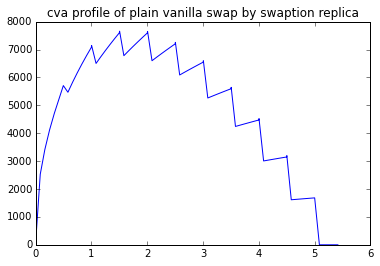

In [22]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.title("cva profile of plain vanilla swap by swaption replica")
plt.plot(check_times,EPE)

In [23]:
# for further references
EPE_Swaption = EPE